In [1]:
import numpy as np
import syndat
import pandas as pd
import os
from matplotlib.pyplot import *


In [2]:
%matplotlib widget

### Define energy grid

In [3]:

energy = np.linspace(55,60,50)
# syndat.sammy_interface.write_estruct_file(energy,'/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/linear_e')

### Look at the fixed ENDF resonances

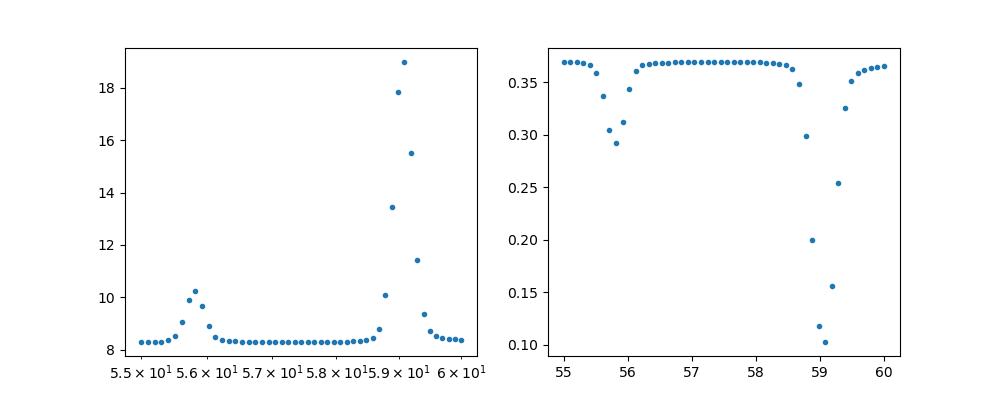

In [4]:

fixed = syndat.sammy_interface.readlst('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/SAMMY_FixedRes.LST') #_FixedRes

fig, ax = subplots(1,2, figsize=(10,4))
ax[0].plot(fixed.E, fixed.theo_xs, '.')
ax[0].set_xscale('log'); #ax[0].set_yscale('log')

# trans = np.exp(-.012*fixed.theo_xs)
ax[1].plot(fixed.E, fixed.theo_trans, '.')
#ax[1].set_xscale('log'); #ax[1].set_yscale('log')

# ****************************************************************
### Approximate open count data from RPI with exponential function

Here the magnitude and function are just toyed around with until the general shape/magnitude of the open count rate is similar. This excludes the fixed notch resonances.


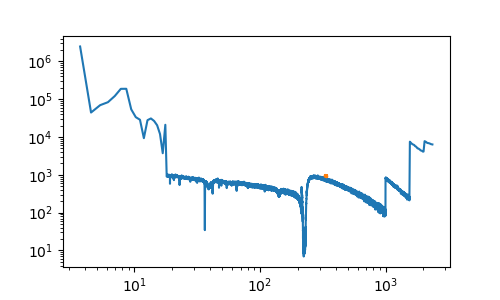

In [5]:
tof = syndat.exp_effects.e_to_t(energy,35.185,True)*1e6

def approx_odat(tof):
    function = 3800*np.exp(-4500*(1e-6*tof))+100
    noisy = syndat.exp_effects.pois_noise(function)
    return noisy

new_open_count_data = approx_odat(tof)

opendata = '/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/rpi-open-ta181.csv'
exp = syndat.experiment(False, True, True, opendata, fixed)
exp.get_odat(opendata)

figure(figsize=(5,3))
plot(exp.odat.tof, exp.odat.c)
plot(tof,new_open_count_data)
xscale('log'); yscale('log')


# ****************************************************************

### Define a new open data df with the appropriate columns, replace it in the exp object


The experiment object in syndat could be improved to take also take a dataframe during initialization


In [22]:
# exp.odat[(exp.odat.E<65)&(exp.odat.E>55)]
# new_open_count_data

In [23]:
new_odat = pd.DataFrame({'tof':tof, 'c':new_open_count_data})
new_odat['dc'] = np.sqrt(new_odat.c)
new_odat['bin_width'] = [0.1024]*len(tof)
# new_odat['E'] = syndat.exp_effects.t_to_e((new_odat.tof-exp.redpar.val.t0)*1e-6, exp.redpar.val.tof_dist, True)
new_odat['E'] = syndat.exp_effects.t_to_e(new_odat.tof*1e-6, 35.185, True)
new_odat['bw'] = new_odat.bin_width*1e-6
# new_odat


# ****************************************************************
### Now add noise with the syndat methodology

Re-define the open data for your experiment, then run the methods

In [8]:

# redefine odat in experiment object
exp.odat = new_odat
# exp.redpar.val.n = 0.012
# run following methods
exp.get_bkg()
exp.get_theoretical(fixed)
exp.generate_sdat(True)
exp.reduce()

#### Inspect the raw count data and transmission data

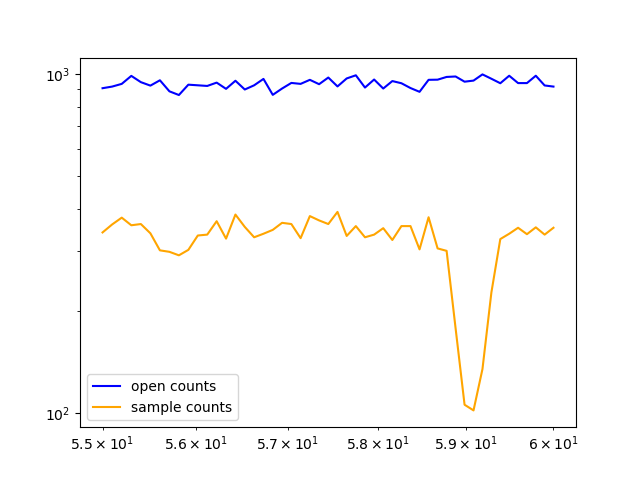

In [9]:
figure()
plot(exp.odat.E, exp.odat.c, 'b',label = 'open counts')
plot(exp.sdat.E,exp.sdat.c,'orange', label = 'sample counts')
# plot(tof, exp.redpar.val.ks*exp.Bi+exp.redpar.val.b0s,'orange', label='bkg_i')
# exp.redpar.val.b0s = exp.redpar.val.b0s - 5
# plot(tof, exp.redpar.val.ks*exp.Bi+exp.redpar.val.b0s, 'orange', '--', label='bkg_i_dec')
# plot(tof, exp.redpar.val.ko*exp.Bi+exp.redpar.val.b0o,'b', label='bkg_o')
legend()
xscale('log'); yscale('log')

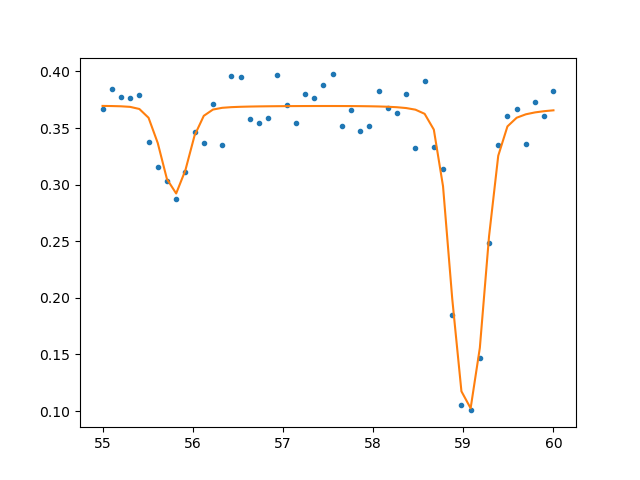

In [10]:

xs_theo = (-1/exp.redpar.val.n)*np.log(exp.trans.theo_trans)
xs_exp = (-1/exp.redpar.val.n)*np.log(exp.trans.exp_trans)

exp.trans['theo_xs'] = xs_theo
exp.trans['exp_xs'] = xs_exp

figure()
plot(exp.trans.E, exp.trans.exp_trans, '.')
plot(exp.trans.E, exp.trans.theo_trans)
# plot(exp.trans.E, exp.trans.exp_xs, '.')
# plot(exp.trans.E, exp.trans.theo_xs)
# xscale('log'); #yscale("log")
# ylim([-0.01, 0.4])

# ****************************************************************
### Now write a function to generate additional resonances 

In [11]:
ac = 8.1271e-15 # scattering radius in m 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 50       # highest order l-wave to consider

pair = syndat.particle_pair(ac, M, m, I, i, l_max)
pair.map_quantum_numbers(True)



The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for negative parity
(J-, #Chs, l-waves)
(0.0, 1, [3.0])
(1.0, 3, [3.0, 3.0, 5.0])
(2.0, 5, [1.0, 3.0, 3.0, 5.0, 5.0])
(3.0, 7, [1.0, 1.0, 3.0, 3.0, 5.0, 5.0, 7.0])
(4.0, 8, [1.0, 1.0, 3.0, 3.0, 5.0, 5.0, 7.0, 7.0])
(5.0, 8, [1.0, 3.0, 3.0, 5.0, 5.0, 7.0, 7.0, 9.0])
(6.0, 8, [3.0, 3.0, 5.0, 5.0, 7.0, 7.0, 9.0, 9.0])
(7.0, 8, [3.0, 5.0, 5.0, 7.0, 7.0, 9.0, 9.0, 11.0])
(8.0, 8, [5.0, 5.0, 7.0, 7.0, 9.0, 9.0, 11.0, 11.0])
(9.0, 8, [5.0, 7.0, 7.0, 9.0, 9.0, 11.0, 11.0, 13.0])
(10.0, 8, [7.0, 7.0, 9.0, 9.0, 11.0, 11.0, 13.0, 13.0])
(11.0, 8, [7.0, 9.0, 9.0, 11.0, 11.0, 13.0, 13.0, 15.0])
(12.0, 8, [9.0, 9.0, 11.0, 11.0, 13.0, 13.0, 15.0, 1

In [12]:


#  sample one res of the same spin group
avg, fixed_res_df = syndat.read_sammy_par('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/SAMNDF_FixedRes.PAR', True)
avg, par = syndat.read_sammy_par('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/endf_eval/SAMNDF.PAR', True)
fixed_res_df


,E,Gg,Gn,jspin
0,55.80,56.0,0.022857,1.0
1,59.05,56.0,0.137140,1.0



Sample an additional resonance of the same spin group.

With a 50% probability, add another $J^{\pi} = 3^+ $. </br> Because it is nontrivial to sample Wigner & PT on top of an existing resonance ladder, the location of the additional resonance will just be sampled as a gaussian centered around the midpoint between the two resonances of the same spin group with a standard deviation 1/3 of the distance to the closest resonance. The width will be sampled from PT with the same average value.

Sample resonances of spin group $J^{\pi} = 2^- $.</br> These resonances are just sampled on top of the existing ladder. Since they are of a different spin group, they have no dependence on the existing resonances.

mugabgab avgs for Ta
D0 = 4.17
S0 = 1.74
S1 = 0.5
S2 = 2.3
G0 = 0.0622
G1 = 0.0434

In [13]:

def sample_a_ladder():

    # constants
    midpoint = np.diff(fixed_res_df.E)/2 + min(fixed_res_df.E)
    std = (midpoint-fixed_res_df.E[0])/3
    j3_D_avg = 8.38
    j3_Gn_avg = 41.12  #milli ev
    j3_Gg_avg = 60 # milli-ev
    j2n_Gg_avg = 50
    j2n_Gn_avg = 0.02 #20.8 # artificially making this very small !! just moving to p-waves did not make the additional resonances small enough - the fixed resonances are very samll

    j3_bool = np.random.randint(0,2)
    j2n_bool = np.random.randint(0,2)

    if j3_bool == 1:

        # j3_location = np.random.default_rng().normal(midpoint, std)
        # j3_S, j3_P = syndat.scattering_theory.PS_recursive(j3_location, pair.ac, pair.M, pair.m, 0)
        # j3_Gg = syndat.sample_widths.sample_RRR_widths(j3_location, j3_Gg_avg/10000, 10000)
        # j3_Gn = syndat.sample_widths.sample_RRR_widths(j3_location, j3_Gn_avg/7, 7)
        # j3_df = pd.DataFrame({'E':j3_location, 'Gg':[j3_Gg], 'Gn':[j3_Gn], 'jspin':[1.0]}) # pd.concat([fixed_res_df,pd.DataFrame({'E':j3_location, 'Gg':[j3_Gg], 'Gn':[j3_Gn], 'jspin':1.0})])
        # new_res_df = pd.concat([fixed_res_df,j3_df])
        pass

    if j2n_bool == 1:

        j2n_location = syndat.sample_levels.sample_RRR_levels([min(fixed_res_df.E), max(fixed_res_df.E)], 5.0)[0]
        j2n_Gg = syndat.sample_widths.sample_RRR_widths(j2n_location, j2n_Gg_avg/10000, 10000)
        j2n_Gn = syndat.sample_widths.sample_RRR_widths(j2n_location, j2n_Gn_avg/1, 1)
        j2n_df = pd.DataFrame({'E':j2n_location, 'Gg':j2n_Gg, 'Gn':j2n_Gn, 'jspin':np.array([3.0]*len(j2n_location))})
        new_res_df = pd.concat([fixed_res_df, j2n_df])

    else:
        new_res_df = fixed_res_df

    new_res_array = syndat.sammy_interface.create_samtools_array_from_DF(new_res_df, False)

    return new_res_df, new_res_array


df, array = sample_a_ladder()
print(df)





       E    Gg        Gn  jspin
0  55.80  56.0  0.022857    1.0
1  59.05  56.0  0.137140    1.0


### Give the resonance ladder generating function to the MMDA module.

The function creates a directory of many sammy input samples relative to the cwd. Each sample directory id filled with all the necessary files to run sammy in order to get out an experimentally corrected theoretical cross section given a set of resonance parameters.


In [14]:
samples = 5000
case_basename = 'syndat'
run_sammy = False


# syndat.MMDA.create_sammy_runfiles(case_basename, samples, energy, sample_a_ladder,"/Users/noahwalton/Documents/GitHub/nuc_syndat/templates/sammy_template_Ta181_allexp.inp", False,
#                                     run_directory="/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN")



### Use the syndat methodology to add experimental noise to the theoeretical cross sections

After SAMMY has been run, each sample should have a SAMMY.LST file containing the pointwise, theoeretical, experimentally corrected cross section. The following function in the MMDA module pulls that theoretical cross section for each sample and runs it through the syndat.experiment methodology. It then saves a SAMMY.DAT file with the new experimental data and uncertainty.

In [15]:
# need to make this an MMDA module
# avg, fixed_par = syndat.sammy_interface.read_sammy_par('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/SAMNDF_FixedRes.PAR', False)

# for i in range(10000):
#     lst_file = os.path.join("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/synthetic_data", f'SAMMY_smpl_{i}.LST')
#     # theoretical_sdat = syndat.readlst("/Users/noahwalton/Documents/GitHub/nuc_syndat/workspace/SAMMY.LST")

#     exp.get_bkg()
#     exp.get_sdat(lst_file)
#     exp.generate_raw_data(True)
#     exp.reduce_raw_data()
#     exp.trans.sort_values('E', inplace=True, ignore_index=True)
#     # print(exp.trans); print(fixed)

#     datfile = os.path.join("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/synthetic_data", f'SAMMY_smpl_{i}.dat')
#     syndat.sammy_interface.write_samdat(exp.trans[['E','exp_trans','exp_trans_unc']],datfile)

#     # saving residual for Cole's NN training
#     residual = np.array(exp.trans.exp_trans - fixed.theo_trans)
#     # residual.to_csv('residual_data.csv', mode='a', index=False, header=False)
#     with open('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/residual_data.csv', 'a') as f:
#         np.savetxt(f, [residual], delimiter=',')

#     parfile = os.path.join("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/synthetic_data", f'SAMMY_smpl_{i}.par')
#     avg, par = syndat.sammy_interface.read_sammy_par(parfile, False)
#     difference = len(par) - len(fixed_par)
#     with open('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/missing_res.csv', 'a') as f:
#         np.savetxt(f, [difference], delimiter=',')






#### Make sure I wrote residual data correctly

Text(0, 0.5, 'Transmission')

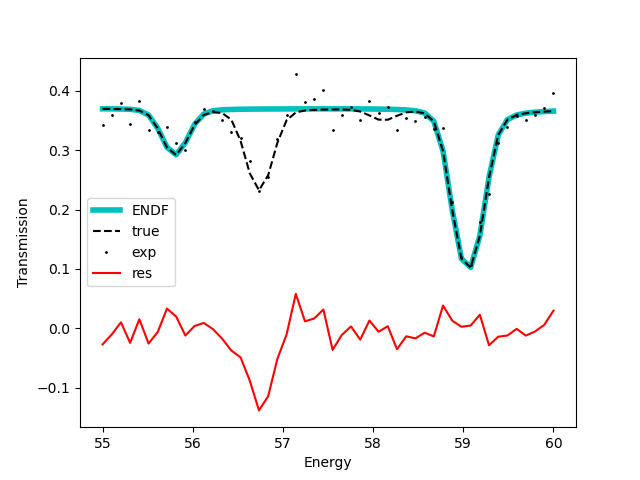

In [16]:
residual_data = np.genfromtxt('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/residual_data.csv', delimiter=',')
fixed = syndat.sammy_interface.readlst("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/SAMMY_FixedRes.LST")

case = 11
sample_theo = syndat.sammy_interface.readlst(f"/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/synthetic_data/SAMMY_smpl_{case}.LST")
sample_exp = syndat.sammy_interface.readlst(f"/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/synthetic_data/SAMMY_smpl_{case}.dat")
# for i in range(1):
#     direct = f"/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/synthetic_data/SAMMY_smpl_{i}.dat"
#     exp_data = syndat.sammy_interface.readlst(direct)
#     residual = exp_data.exp_dat - fixed.theo_trans

figure()
plot(fixed.E, fixed.theo_trans, c='c', lw=4, label='ENDF')
plot(sample_theo.E, sample_theo.theo_trans,'k--', label='true')
plot(sample_exp.E, sample_exp.exp_dat, 'k.', ms=2, label='exp')
plot(fixed.E, residual_data[case], c='r', label='res')
legend()

xlabel('Energy')
ylabel("Transmission")
# plot(fixed.E, other.theo_trans-other.theo_trans)

In [17]:
# get a solution for resonances between the two endf resonances
# avg, fixed_par = syndat.sammy_interface.read_sammy_par('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/SAMNDF_FixedRes.PAR', False)
# residual_data = np.genfromtxt('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/residual_data.csv', delimiter=',')

# residual_dat_nores = []
# for i in range(10000):
#     parfile = os.path.join("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/synthetic_data", f'SAMMY_smpl_{i}.par')
#     avg, par = syndat.sammy_interface.read_sammy_par(parfile, False)
#     difference = len(par) - len(fixed_par)
#     # with open('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/missing_res_.csv', 'a') as f:
#     #     np.savetxt(f, [difference], delimiter=',')
#     if difference == 0:
#          residual_dat_nores.append(residual_data[i])
# difference
# print(fixed_par)
# print(par)

### Ensure that I am writing out the proper residual and the sample number's line up

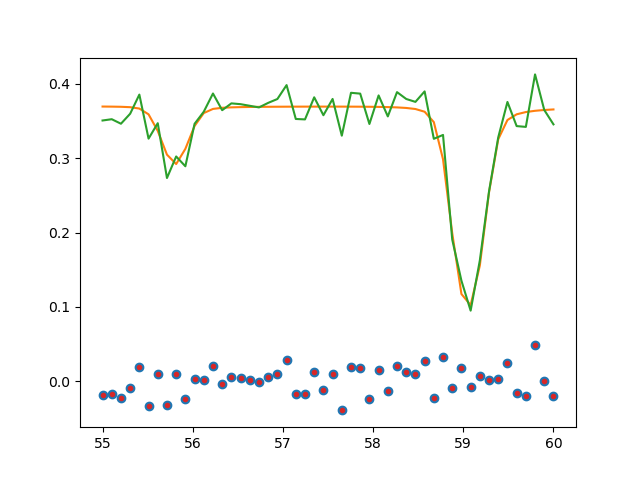

In [18]:

datfile = os.path.join("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/synthetic_data", f'SAMMY_smpl_101.dat')
test = syndat.sammy_interface.readlst(datfile)
test2 = np.genfromtxt('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/cole_NN/residual_data.csv', delimiter=',')

figure()
plot(test.E, test.exp_dat-fixed.theo_trans,'o') #
plot(fixed.E, fixed.theo_trans)
plot(test.E, test.exp_dat)
plot(test.E, test2[101], '.')
# test